Using the data from last class (regression_data.csv), try the find the best combination of preprocessing and model parameters to set the best model based on their basic metrics, MSE and R2. In the notebook, add a markdown to explain the different processes you have applied.

In [811]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import math
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [812]:
data = pd.read_csv('regression_data1.txt')
data.head()

,HV1,IC1,IC2,IC3,IC4,IC5,AVGGIFT,TARGET_D
0,2346,420,446,468,503,14552,15.500000,21.0
1,497,350,364,357,384,11696,3.080000,3.0
2,1229,469,502,507,544,17313,7.500000,20.0
3,325,148,181,171,209,6334,6.700000,5.0
4,768,174,201,220,249,7802,8.785714,10.0


In [813]:
data.shape

(4843, 8)

In [814]:
def linearmodel(data):
    y = data['TARGET_D']
    X = data.drop(columns=['TARGET_D']) # drop the constant

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # split the data
    lm = linear_model.LinearRegression() # create the model
    lm.fit(X_train, y_train) # train the model
    predictions = lm.predict(X_test) # calculate predictions

    r2 = r2_score(y_test, predictions)
    print(f'R2: {r2:.8f}')
    mse = mean_squared_error(y_test, predictions)
    print(f'MSE: {mse:.8f}')
    mape = np.mean(np.abs((y_test - predictions)/y_test)*100)
    print(f'MAPE: {mape:.8f}%')

# From previous lessons

## R2 and MSE

The results are not good... We haven't treated the variables, let's take a general look with a heatmap

<Axes: >

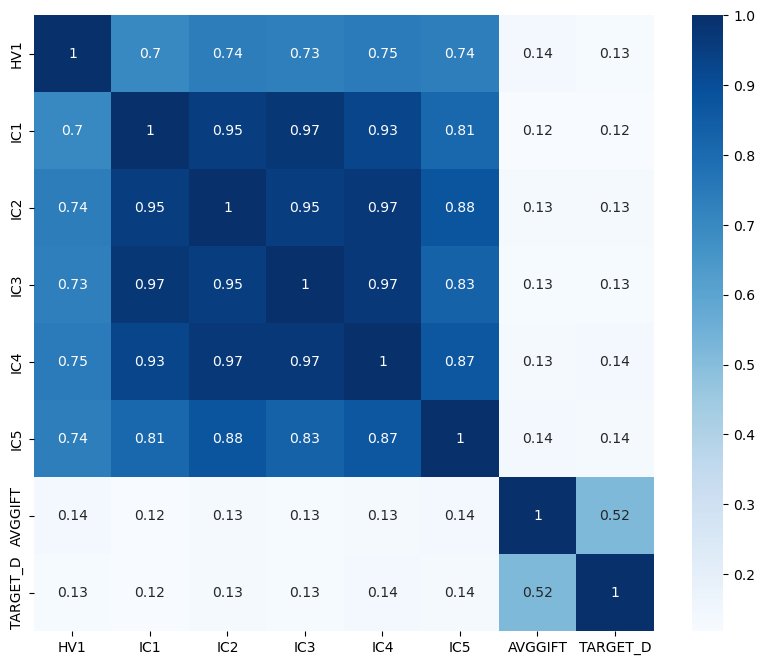

In [816]:
# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),
            annot=True, 
            cmap='Blues'
            )

The ``IC`` variables have a really high correlation with each other, meaning we have a problem of collinearity. 

## VIF

Let's take a look at the VIF (Variance Inflation Factor) so we can see if there is multicollinearity.

In [817]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [818]:
vif_data = pd.DataFrame()
vif_data['Variables'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif_data

,Variables,VIF
0,HV1,5.132969
1,IC1,278.050431
2,IC2,270.744404
3,IC3,638.040583
4,IC4,535.404193
5,IC5,19.312516
6,AVGGIFT,3.179431
7,TARGET_D,3.431505


As we suspected, we have a problem, VIF can be maximum 10. We apply the following function to get rid one by one of the variable with the highest VIF.

In [819]:
def calcular_vif(data):
    """Calcula el VIF para cada variable en el DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

def eliminar_variables_vif(data, umbral=10):
    """
    Elimina las variables con el mayor VIF de forma iterativa 
    hasta que todas las variables tengan un VIF inferior al umbral.
    """
    iteracion = 1
    while True:
        print(f"\n--- Iteración {iteracion} ---")
        

        vif_data = calcular_vif(data)
        print(vif_data)
        
        max_vif = vif_data["VIF"].max()
        if max_vif < umbral:
            print("\n✅ Todas las variables tienen VIF menor que", umbral)
            break
        

        variable_a_eliminar = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"\n⚠️ Se eliminará la variable con mayor VIF: {variable_a_eliminar} (VIF={max_vif})")
        
        data = data.drop(columns=[variable_a_eliminar])
        
        iteracion += 1
        
    print("\n📊 Proceso finalizado. Variables restantes:")
    print(data.columns)
    return data, vif_data

data_final, vif_final = eliminar_variables_vif(data, umbral=10)


--- Iteración 1 ---
   Variable         VIF
0       HV1    5.132969
1       IC1  278.050431
2       IC2  270.744404
3       IC3  638.040583
4       IC4  535.404193
5       IC5   19.312516
6   AVGGIFT    3.179431
7  TARGET_D    3.431505

⚠️ Se eliminará la variable con mayor VIF: IC3 (VIF=638.040583411328)

--- Iteración 2 ---
   Variable         VIF
0       HV1    5.106407
1       IC1   57.677729
2       IC2  168.759016
3       IC4   98.405392
4       IC5   18.987081
5   AVGGIFT    3.174978
6  TARGET_D    3.430791

⚠️ Se eliminará la variable con mayor VIF: IC2 (VIF=168.75901550761108)

--- Iteración 3 ---
   Variable        VIF
0       HV1   5.096261
1       IC1  36.643465
2       IC4  49.687661
3       IC5  16.947173
4   AVGGIFT   3.174812
5  TARGET_D   3.428213

⚠️ Se eliminará la variable con mayor VIF: IC4 (VIF=49.68766066801159)

--- Iteración 4 ---
   Variable        VIF
0       HV1   5.095969
1       IC1  12.945643
2       IC5  13.876035
3   AVGGIFT   3.128211
4  TARGET_D   3.

We got rid of all the ``IC`` except ``IC1``.

In [820]:
data_final

,HV1,IC1,AVGGIFT,TARGET_D
0,2346,420,15.500000,21.0
1,497,350,3.080000,3.0
2,1229,469,7.500000,20.0
3,325,148,6.700000,5.0
4,768,174,8.785714,10.0
...,...,...,...,...
4838,701,297,15.500000,25.0
4839,3357,284,11.857143,19.0
4840,700,322,11.333333,10.0
4841,601,206,13.000000,25.0


In [821]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HV1       4843 non-null   int64  
 1   IC1       4843 non-null   int64  
 2   AVGGIFT   4843 non-null   float64
 3   TARGET_D  4843 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 151.5 KB


So we are left with only numerical variables

# Numerical preprocessing

In [822]:
numericals = data_final.copy()

In [823]:
linearmodel(numericals)

R2: -1.25456637
MSE: 327.00136153
MAPE: 43.04035436%


Let's check if we have null values

In [824]:
numericals.isna().sum()

HV1         0
IC1         0
AVGGIFT     0
TARGET_D    0
dtype: int64

## Outliers

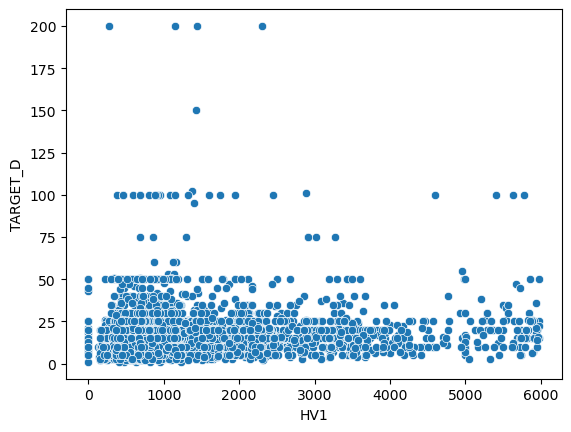

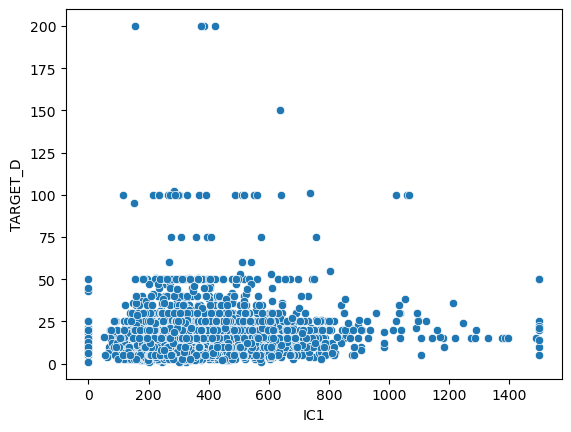

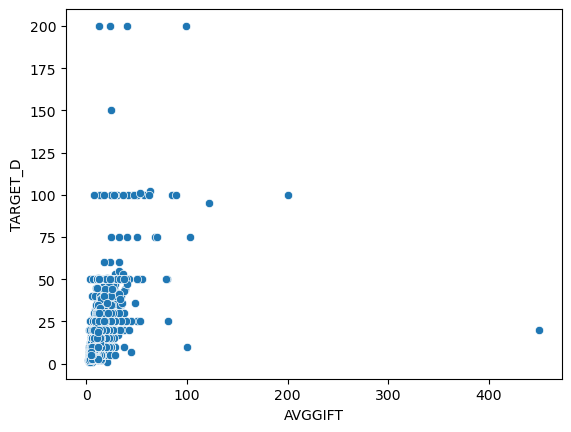

In [825]:
for column in numericals.drop(columns='TARGET_D').columns:
    sns.scatterplot(data=numericals, x=column, y='TARGET_D')
    plt.show()

In [826]:
data['mitjana'] = data['AVGGIFT'] / data['TARGET_D'] # create a new column
data.sort_values('mitjana', ascending=False).head()

,HV1,IC1,IC2,IC3,IC4,IC5,AVGGIFT,TARGET_D,mitjana
2662,2067,489,534,540,583,19624,450.000000,20.0,22.500000
1134,629,306,452,450,559,24173,20.428571,1.0,20.428571
2891,5377,671,949,811,922,37647,100.000000,10.0,10.000000
2084,546,191,208,219,234,5846,14.800000,2.0,7.400000
2977,435,244,300,278,326,11022,44.700000,7.0,6.385714


In [827]:
data[data['AVGGIFT']>400] # not representative, donation (TARGET_D) too small for such an average donation (AVG_GIFT)

,HV1,IC1,IC2,IC3,IC4,IC5,AVGGIFT,TARGET_D,mitjana
2662,2067,489,534,540,583,19624,450.0,20.0,22.5


In [828]:
data.drop(columns='mitjana', inplace=True) # we don't need this newly created column anymore

# delete this extreme value
numericals.AVGGIFT = np.where(numericals['AVGGIFT']>190, np.nan, numericals.AVGGIFT)
numericals = numericals.dropna()
numericals.reset_index(drop=True, inplace=True)
numericals.isna().sum()

HV1         0
IC1         0
AVGGIFT     0
TARGET_D    0
dtype: int64

In [829]:
linearmodel(numericals)

R2: 0.47822422
MSE: 74.06339738
MAPE: 39.02813838%


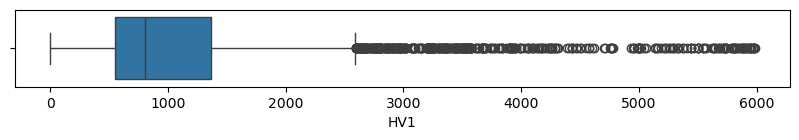

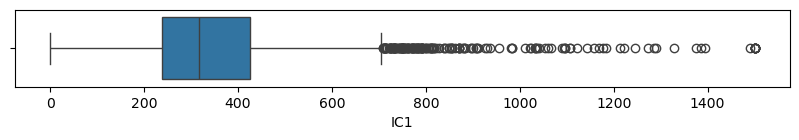

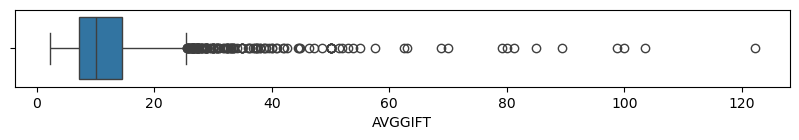

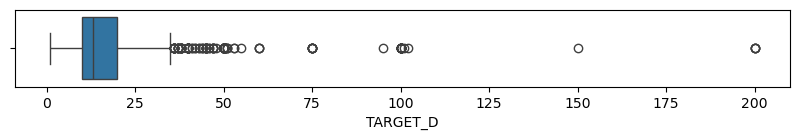

In [830]:
for column in numericals.columns:
    plt.figure(figsize=(10,1))
    sns.boxplot(data=numericals, x=column)
    plt.show()

We have many outliers in the upper end, especially in ``AVGGIFT`` and ``TARGET_D``, meaning they are positively skewed.

We can apply one of 2 transformations: logaritmic and squared.

### ``AVGGIFT`` transformation

#### Logaritmic transformation

In [831]:
# we create a function
def log_trans(x):
    if np.isfinite(x) and x!=0: 
        return np.log(x)
    else:
        return np.NAN # we transform the negatives and 0 values to nan so we can transform them later comfortably

<Axes: >

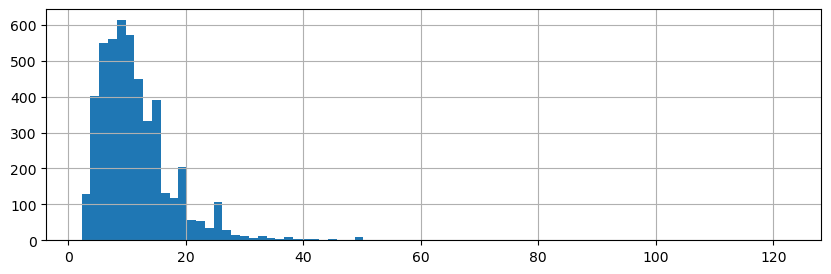

In [832]:
plt.figure(figsize=(10,3))
numericals['AVGGIFT'].hist(bins=80)

<Axes: >

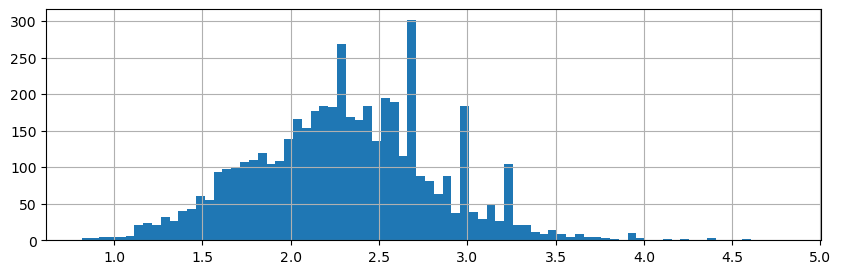

In [833]:
plt.figure(figsize=(10,3))
pd.Series(map(log_trans, numericals['AVGGIFT'])).hist(bins=80)

#### Square root transformation

In [834]:
def squared(x):
    if np.isfinite and x >= 0:
        return np.sqrt(x)
    else:
        return np.NAN

<Axes: >

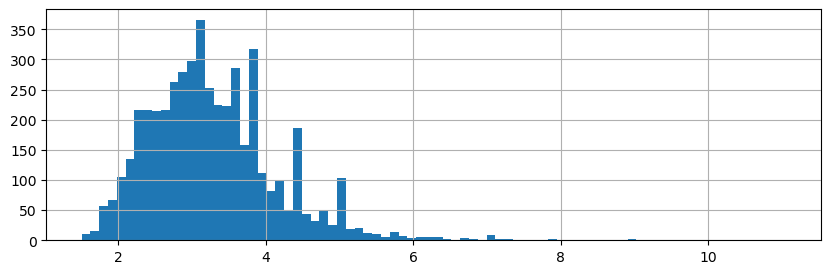

In [835]:
plt.figure(figsize=(10,3))
pd.Series(map(squared, numericals['AVGGIFT'])).hist(bins=80)

The logaritmic transformation leaves us with a smaller range, so I prefer to use this one

In [836]:
numericals.isna().sum() # check there are no nulls

HV1         0
IC1         0
AVGGIFT     0
TARGET_D    0
dtype: int64

In [837]:
numericals['AVGGIFT'] = np.log(numericals['AVGGIFT']) # apply the logaritmic transformation to the 'AVGGIFT' column

<Axes: xlabel='AVGGIFT'>

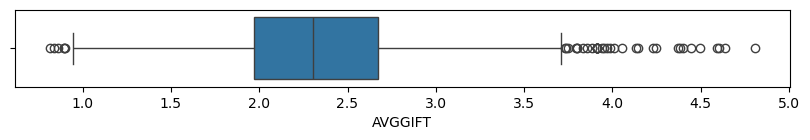

In [838]:
plt.figure(figsize=(10,1))
sns.boxplot(data=numericals, x='AVGGIFT') # display the boxplot

In [839]:
linearmodel(numericals)

R2: 0.44449274
MSE: 78.85140844
MAPE: 39.16952083%


### ``TARGET_D`` transformation

#### Logaritmic transformation

<Axes: >

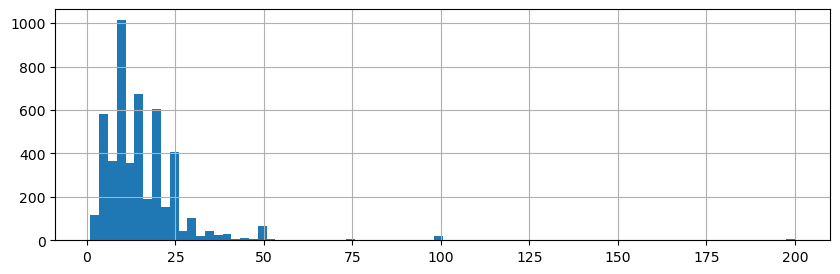

In [841]:
plt.figure(figsize=(10,3))
numericals['TARGET_D'].hist(bins=80)

<Axes: >

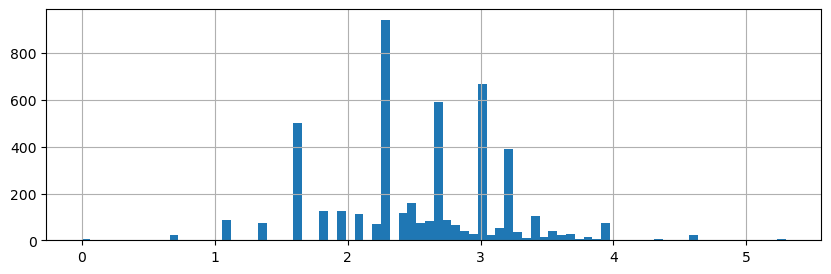

In [842]:
plt.figure(figsize=(10,3))
pd.Series(map(log_trans, numericals['TARGET_D'])).hist(bins=80)

#### Square root transformation

<Axes: >

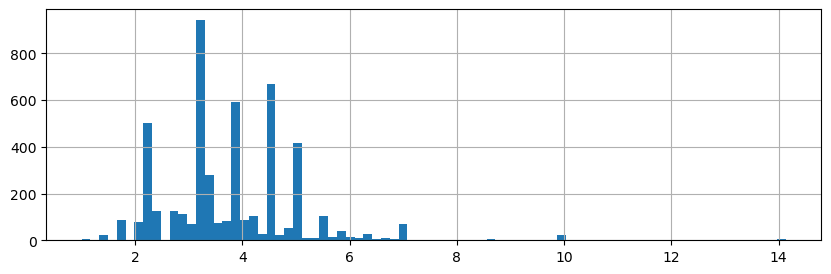

In [843]:
plt.figure(figsize=(10,3))
pd.Series(map(squared, numericals['TARGET_D'])).hist(bins=80)

The logaritmic transformation leaves us with a smaller range, so I prefer to use this one

In [844]:
numericals['TARGET_D'] = np.log(numericals['TARGET_D'])
numericals

,HV1,IC1,AVGGIFT,TARGET_D
0,2346,420,2.740840,3.044522
1,497,350,1.124930,1.098612
2,1229,469,2.014903,2.995732
3,325,148,1.902108,1.609438
4,768,174,2.173127,2.302585
...,...,...,...,...
4836,701,297,2.740840,3.218876
4837,3357,284,2.472930,2.944439
4838,700,322,2.427748,2.302585
4839,601,206,2.564949,3.218876


# Checking the quality of the model

In [845]:
numericals

,HV1,IC1,AVGGIFT,TARGET_D
0,2346,420,2.740840,3.044522
1,497,350,1.124930,1.098612
2,1229,469,2.014903,2.995732
3,325,148,1.902108,1.609438
4,768,174,2.173127,2.302585
...,...,...,...,...
4836,701,297,2.740840,3.218876
4837,3357,284,2.472930,2.944439
4838,700,322,2.427748,2.302585
4839,601,206,2.564949,3.218876


## Linear Model

In [846]:
linearmodel(numericals)

R2: 0.58142772
MSE: 0.17423355
MAPE: inf%


In [847]:
numericals.TARGET_D.min()

0.0

MAPE is infinite because we have donations that are 0

### Ridge

In [848]:
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]
for i in alphas:
    ridge = Ridge(alpha=i) 
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    print(f"📘 Ridge with alpha = {i}")
    print(f"R2: {r2_ridge:.8f}")
    print(f"MSE: {mse_ridge:.8f}")

📘 Ridge with alpha = 0.01
R2: 0.58142738
MSE: 0.17423368
📘 Ridge with alpha = 0.1
R2: 0.58142438
MSE: 0.17423494
📘 Ridge with alpha = 1
R2: 0.58139389
MSE: 0.17424763
📘 Ridge with alpha = 10
R2: 0.58104824
MSE: 0.17439151
📘 Ridge with alpha = 100
R2: 0.57423567
MSE: 0.17722729


The best is alpha = 0.01

In [849]:
# let's try scaling the features
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

alpha=0.01
ridge = Ridge(alpha=alpha)
ridge.fit(scaled_X_train, y_train)
y_pred_ridge = ridge.predict(scaled_X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"📘 Ridge with alpha = {alpha}")
print(f"R2: {r2_ridge:.8f}")
print(f"MSE: {mse_ridge:.8f}")

📘 Ridge with alpha = 0.01
R2: 0.58142763
MSE: 0.17423358


It's almost the same, scaling doesn't really affect here.

### Lasso

In [850]:
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

alphas = [0.0001, 0.001, 0.01, 0.1, 1]
for i in alphas:
    lasso = Lasso(alpha=i) 
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)

    r2_lasso = r2_score(y_test, y_pred_lasso)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)

    print(f"📘 Lasso with alpha = {i}")
    print(f"R2: {r2_lasso:.8f}")
    print(f"MSE: {mse_lasso:.8f}")

📘 Lasso with alpha = 0.0001
R2: 0.58141347
MSE: 0.17423948
📘 Lasso with alpha = 0.001
R2: 0.58127716
MSE: 0.17429622
📘 Lasso with alpha = 0.01
R2: 0.57911044
MSE: 0.17519813
📘 Lasso with alpha = 0.1
R2: 0.47705319
MSE: 0.21768015
📘 Lasso with alpha = 1
R2: 0.02163264
MSE: 0.40725204


Here the best is alpha = 0.0001

In [851]:
'''
📘 Ridge with alpha = 0.01
R2: 0.58142763
MSE: 0.17423358
MAPE: inf%

📘 Lasso with alpha = 0.0001
R2: 0.58141347
MSE: 0.17423948
MAPE: inf%
'''

'\n📘 Ridge with alpha = 0.01\nR2: 0.58142763\nMSE: 0.17423358\nMAPE: inf%\n\n📘 Lasso with alpha = 0.0001\nR2: 0.58141347\nMSE: 0.17423948\nMAPE: inf%\n'

They are both almost the same

In [852]:
# let's try scaling the features
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

alpha=0.0001
lasso = Lasso(alpha=alpha)
lasso.fit(scaled_X_train, y_train)
y_pred_lasso = lasso.predict(scaled_X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print(f"📘 Lasso with alpha = {alpha}")
print(f"R2: {r2_lasso:.8f}")
print(f"MSE: {mse_lasso:.8f}")

📘 Lasso with alpha = 0.0001
R2: 0.58142860
MSE: 0.17423318


Like before, it's almost the same, scaling doesn't really affect here.

### Polynomial features

In [853]:
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

degrees = range(1,10)
for degree in degrees:
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    poly_reg.fit(scaled_X_train, y_train)
    y_train_pred = poly_reg.predict(scaled_X_train)
    y_test_pred = poly_reg.predict(scaled_X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_poly = mean_squared_error(y_test, y_test_pred)

    print(f"📘 Polynomial features with degree = {degree}")
    print(f"R2 train: {r2_train:.8f}")
    print(f"R2 test: {r2_test:.8f}")
    print(f"MSE: {mse_poly:.8f}\n")

📘 Polynomial features with degree = 1
R2 train: 0.55927640
R2 test: 0.58142772
MSE: 0.17423355

📘 Polynomial features with degree = 2
R2 train: 0.56475667
R2 test: 0.58746272
MSE: 0.17172144

📘 Polynomial features with degree = 3
R2 train: 0.56679877
R2 test: 0.58387559
MSE: 0.17321460

📘 Polynomial features with degree = 4
R2 train: 0.57052755
R2 test: 0.58645138
MSE: 0.17214241

📘 Polynomial features with degree = 5
R2 train: 0.57480643
R2 test: 0.58533056
MSE: 0.17260896

📘 Polynomial features with degree = 6
R2 train: 0.57944387
R2 test: 0.56805524
MSE: 0.17979993

📘 Polynomial features with degree = 7
R2 train: 0.58406567
R2 test: 0.30551894
MSE: 0.28908244

📘 Polynomial features with degree = 8
R2 train: 0.58868648
R2 test: 0.50850151
MSE: 0.20458957

📘 Polynomial features with degree = 9
R2 train: 0.59557073
R2 test: -3.95316752
MSE: 2.06178951



The best is **degree 5**

## KNN

### looking for the best metric

In [854]:
# let's try scaling the features
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # split the data

# Scale the features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

metrics=["euclidean", "manhattan", "minkowski"]
n=[3, 5, 7, 9]

for neighbor in n:
    for metric in metrics:
        knn_reg = KNeighborsRegressor(n_neighbors=neighbor, weights='distance', metric=metric, p=3)
        knn_reg.fit(scaled_X_train, y_train)
        y_pred = knn_reg.predict(scaled_X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred)/y_test)*100)

        print(f"📘 KNN with {neighbor} neighbors, weight = 'uniform', metric = {metric}")
        print(f"R2 test: {r2:.8f}")
        print(f"MAPE: {mape:.8f}%")
        print(f"MSE: {mse:.8f}\n")

📘 KNN with 3 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.43063108
MAPE: inf%
MSE: 0.23700367

📘 KNN with 3 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.42476860
MAPE: inf%
MSE: 0.23944396

📘 KNN with 3 neighbors, weight = 'uniform', metric = minkowski
R2 test: 0.42149692
MAPE: inf%
MSE: 0.24080583

📘 KNN with 5 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.47257050
MAPE: inf%
MSE: 0.21954610

📘 KNN with 5 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.47398289
MAPE: inf%
MSE: 0.21895818

📘 KNN with 5 neighbors, weight = 'uniform', metric = minkowski
R2 test: 0.47607704
MAPE: inf%
MSE: 0.21808648

📘 KNN with 7 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.50415175
MAPE: inf%
MSE: 0.20640019

📘 KNN with 7 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.50179021
MAPE: inf%
MSE: 0.20738320

📘 KNN with 7 neighbors, weight = 'uniform', metric = minkowski
R2 test: 0.51142949
MAPE: inf%
MSE: 0.20337078

📘

### looking for the ideal number of neighbors

In [855]:
# the best metric is Minkowski
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # split the data

# Scale the features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

r2score = 0
best_neighbor = 0
n = range(1,99,2)

for neighbor in n:
    knn_reg = KNeighborsRegressor(n_neighbors=neighbor, weights='distance', metric='minkowski', p=3)
    knn_reg.fit(scaled_X_train, y_train)
    y_pred = knn_reg.predict(scaled_X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred)/y_test)*100)

    print(f"📘 KNN with {neighbor} neighbors, weight = 'uniform', metric = 'minkowski'")
    print(f"R2 test: {r2:.5f}")
    print(f"MAPE: {mape:.5f}%")
    print(f"MSE: {mse:.5f}\n")

    if r2 > r2score: # for loop to determine the best number of neighbors based on the r2 score
        r2score = r2
        best_neighbor = neighbor

print(f'Ideal number of neighbors: {best_neighbor}')

📘 KNN with 1 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.13723
MAPE: inf%
MSE: 0.35913

📘 KNN with 3 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.42150
MAPE: inf%
MSE: 0.24081

📘 KNN with 5 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.47608
MAPE: inf%
MSE: 0.21809

📘 KNN with 7 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.51143
MAPE: inf%
MSE: 0.20337

📘 KNN with 9 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.52556
MAPE: inf%
MSE: 0.19749

📘 KNN with 11 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.53728
MAPE: inf%
MSE: 0.19261

📘 KNN with 13 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.54180
MAPE: inf%
MSE: 0.19073

📘 KNN with 15 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.55080
MAPE: inf%
MSE: 0.18698

📘 KNN with 17 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.55445
MAPE: inf%
MSE: 0.18546

📘 KNN with 19 neighbors, weight =

In [856]:
y = numericals['TARGET_D']
X = numericals.drop(columns=['TARGET_D']) # drop the constant

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # split the data

# Scale the features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=81, weights='distance', metric='minkowski', p=3)
knn_reg.fit(scaled_X_train, y_train)
y_pred = knn_reg.predict(scaled_X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred)/y_test)*100)

print(f"📘 KNN with 81 neighbors, weight = 'uniform', metric = 'minkowski'")
print(f"R2 test: {r2:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"MSE: {mse:.5f}\n")

📘 KNN with 81 neighbors, weight = 'uniform', metric = 'minkowski'
R2 test: 0.57481
MAPE: inf%
MSE: 0.17699



In [857]:
'''
📘 Lasso with alpha = 0.0001
R2: 0.58142860
MSE: 0.17423318
MAPE: inf%

📘 Ridge with alpha = 0.01
R2: 0.58142763
MSE: 0.17423358
MAPE: inf%

Linear Model
R2: 0.58142772
MSE: 0.17423355
'''

'\n📘 Lasso with alpha = 0.0001\nR2: 0.58142860\nMSE: 0.17423318\nMAPE: inf%\n\n📘 Ridge with alpha = 0.01\nR2: 0.58142763\nMSE: 0.17423358\nMAPE: inf%\n\nLinear Model\nR2: 0.58143\nMSE: 0.17423\nMAPE: inf%\n'

So we can conclude Ridge and Lasso are almost identical and slightly better than KNN